## Introduction

#### Motivation

We are interested in helping revamp the ATOC Skywatch data archives and make the data more accessible and easier to visualize. We chose to work with data from the ceilometer and pyrgeometer and look at the cloud base heights as well as derive the cloud base heights using Stefan-Boltzmann's Law. We then turned our data reader into a function so that we could create a 'climatology' of cloud base data to see if there are any useful trends. 

#### Data Sets Used and References

1. Skywatch Archives: Ceilometer
2. Skywatch Archives: Pyrgeometer
3. https://en.wikipedia.org/wiki/Pyrgeometer
4. http://weather.uwyo.edu/upperair/sounding.html

## Algorithm

#### Cielometer Data - For One Day

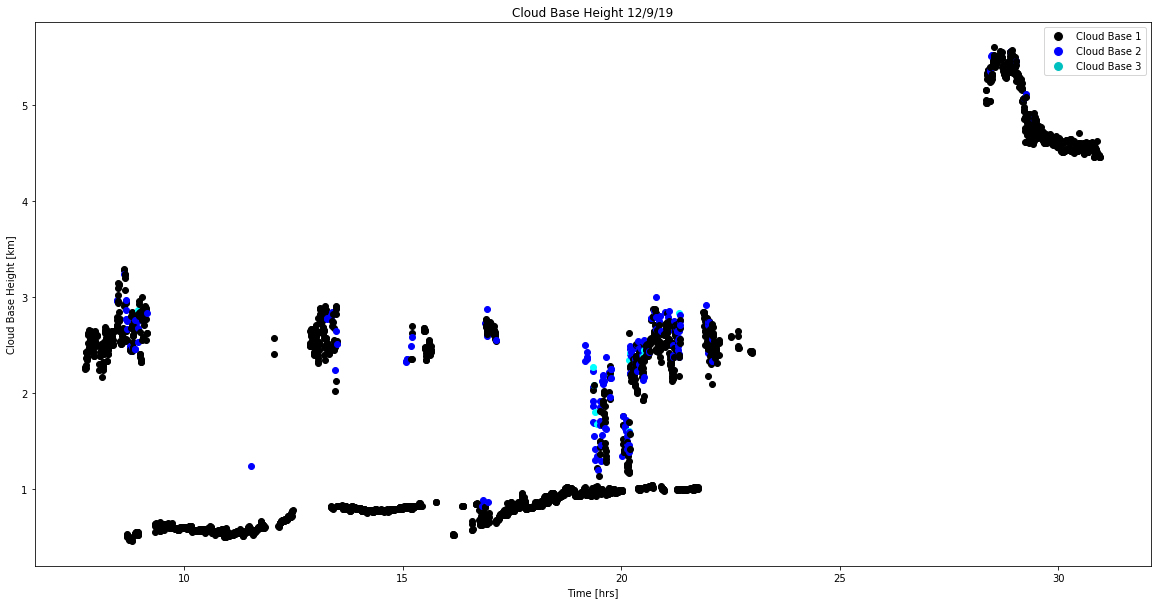

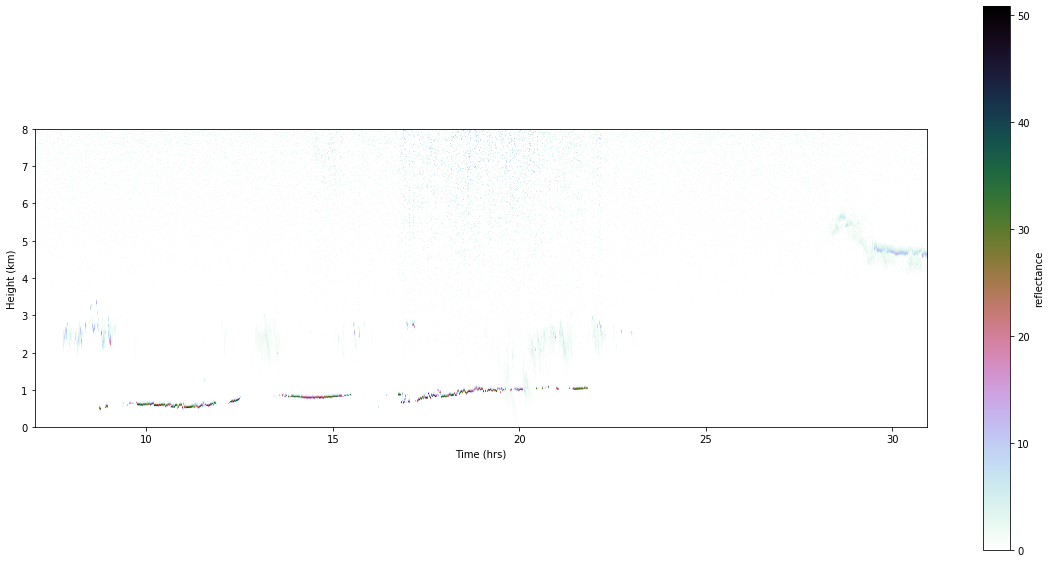

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import urllib
from matplotlib.lines import Line2D
import datetime
from matplotlib.pyplot import cm
import calendar
import h5py
import os.path
from sys import exit as ext
%matplotlib inline

url    = 'https://skywatch.colorado.edu/data/ceil_19_12_09.dat'
lines  = urllib.request.urlopen(url).readlines()

# Loop over the lines in the file
utc=[] # initialize list for times
cloud_base1 = [] #initialize lists for cloud base heights
cloud_base2 = []
cloud_base3 = []

timesteps = len(lines) - 5 #Number of timesteps in the datafile. Minus five due to header lines

reflectance_data = np.zeros((770,timesteps)) #initialize reflectance data array

#Loop through all lines in datafile. 
for i,line in enumerate(lines):
    entries = line.decode("utf-8").split("\t")
    #print(entries);quit()
    if entries[0][0] != ';':
        utc.append(float(entries[0][0:2]) + \
                   float(entries[0][3:5])/60. + \
                   float(entries[0][6:8])/3600.)
        cloud_base1.append(float(entries[1])/1000)  
        cloud_base2.append(float(entries[2])/1000)
        cloud_base3.append(float(entries[3])/1000)
    
        #Create the reflectance data matrix
        ref1 = np.array(entries[4:774], dtype=np.float64) 
        reflectance_data[:,i-5] = ref1
        
        #Initialize a variable to capture the start time of the dataset
        if i==5:
            start_time = int(float(entries[0][0:2]) + \
                   float(entries[0][3:5])/60. + \
                   float(entries[0][6:8])/3600.)

#Ensure that the time does not start over after 24 hours and is continuous 
utc=np.array(utc)
next_day=np.where(utc < start_time)
utc[next_day]=utc[next_day]+24.
   
#Prepare reflectance data for plotting
reflectance_data = np.flipud(reflectance_data)
reflectance_data = np.where(reflectance_data < 0 , 0, reflectance_data)
plt.figure(figsize = [20, 10])

#Plot cloud base heights that are not zero
for i in range(len(cloud_base1)):
    
    if cloud_base1[i] != 0: 
        plt.plot(utc[i], cloud_base1[i], 'o', color = 'black')
        
    if cloud_base2[i] != 0:
        plt.plot(utc[i], cloud_base2[i], 'o', color= 'blue')
    
    if cloud_base3[i] != 0:
        plt.plot(utc[i], cloud_base3[i], 'o', color= 'cyan')
        
plt.xlabel('Time [hrs]')
plt.ylabel('Cloud Base Height [km]')
plt.title('Cloud Base Height 12/9/19')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cloud Base 1', markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Cloud Base 2', markerfacecolor='b', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Cloud Base 3', markerfacecolor='c', markersize=10)]

plt.legend(handles=legend_elements)

plt.show()

#Plot reflectance data
size = [utc[0], utc[-1], 0, 8]

fig = plt.figure(figsize = [20, 10])
plt.imshow(reflectance_data, cmap = 'cubehelix_r', extent = size)
plt.xlabel('Time (hrs)')
plt.ylabel('Height (km)')
plt.colorbar(label='reflectance')
plt.show()

The first plot shows the cloud base data for cloud bases 1, 2, and 3. Any cloud heights that were zero were not included in the plot. As is evident by the first plot, the first cloud base is the most prominent. The second plot shows the backscatter from the cielometer. The data from this plot can also be used to determine cloud base height, as the largest backscatter values indicate where a cloud has formed. 

#### Pyrgeometer Data - One Day

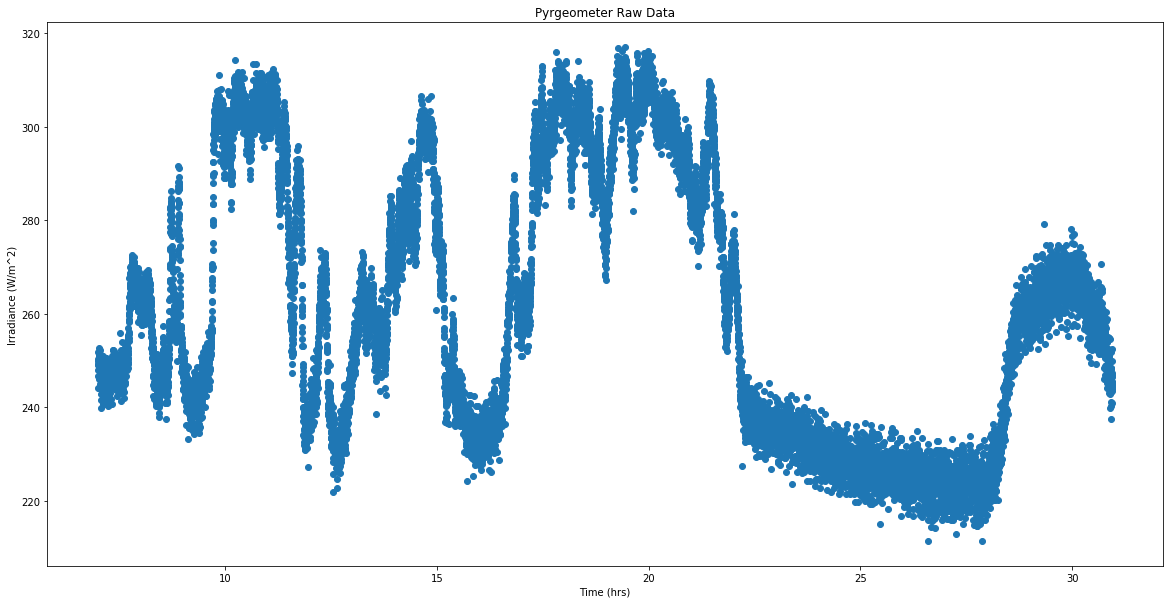

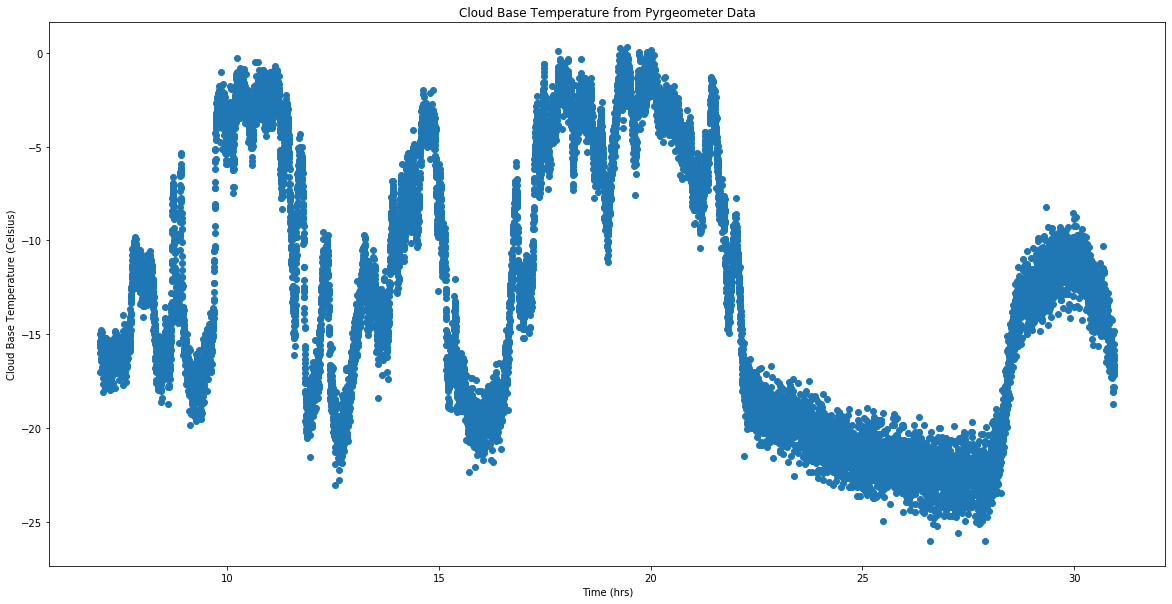

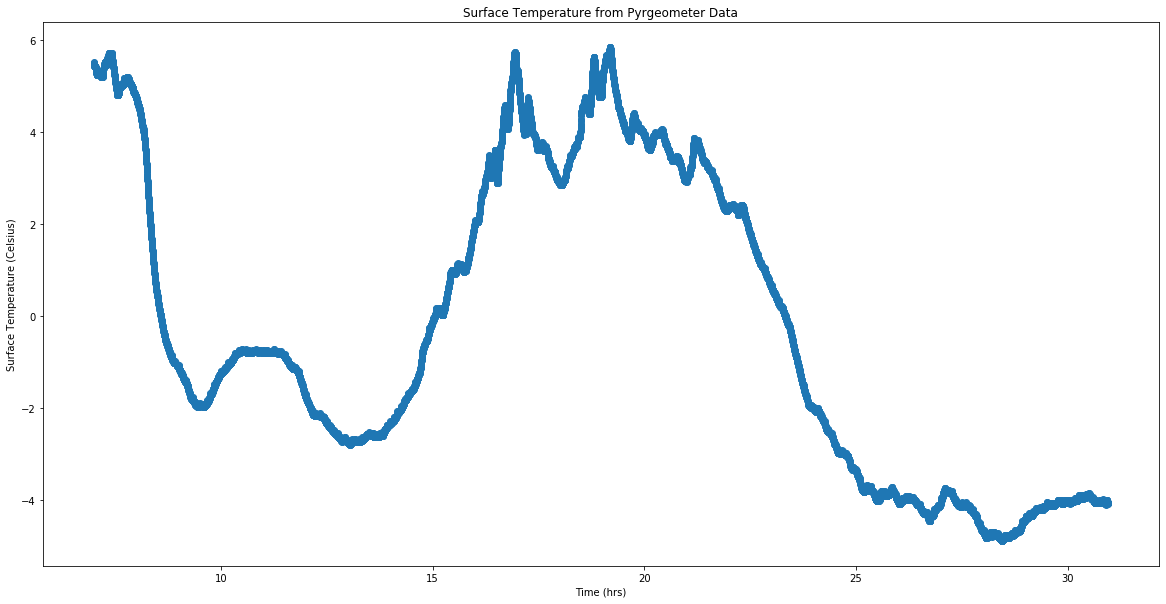

In [13]:
url    = 'https://skywatch.colorado.edu/data/pyrg_19_12_09.dat'
lines  = urllib.request.urlopen(url).readlines()

# Loop over the lines in the file
utc_p=[] # initialize list for times
irradiance = []
surface_temp = []
T_derived = []




for i,line in enumerate(lines):
    entries = line.decode("utf-8").split("\t")
    #print(entries);quit()
    if entries[0][0] != ';':
        utc_p.append(float(entries[0][0:2]) + \
                   float(entries[0][3:5])/60. + \
                   float(entries[0][6:8])/3600.)
        irradiance.append(float(entries[1]))  #W/m^2
        surface_temp.append(float(entries[3]) - 273.1) #Celsius 
        
        #Calculate derived temperature using Stefan Boltzmann's Law
        T_derived.append((float(entries[1])/(5.67*10**(-8)))**(1/4) - 273.15)
        
        #Calculate the time at which the data file starts, the header is 5 lines so look after the header. 
        if i==5:
            start_time = int(float(entries[0][0:2]) + \
                   float(entries[0][3:5])/60. + \
                   float(entries[0][6:8])/3600.)

#Make sure that the data is continuous, so instead of returning to 0 after 23 hours, it goes on to 24 and up. 
utc_p=np.array(utc_p)
next_day=np.where(utc_p < start_time)
utc_p[next_day]=utc_p[next_day]+24.


#Plot data
plt.figure(figsize = [20, 10])
plt.scatter(utc_p, irradiance)
plt.xlabel('Time (hrs)')
plt.ylabel('Irradiance (W/m^2)')
plt.title('Pyrgeometer Raw Data')
plt.show()

plt.figure(figsize = [20, 10])
plt.scatter(utc_p, T_derived)
plt.xlabel('Time (hrs)')
plt.ylabel('Cloud Base Temperature (Celsius)')
plt.title('Cloud Base Temperature from Pyrgeometer Data')
plt.show()


plt.figure(figsize = [20, 10])
plt.scatter(utc_p, surface_temp)
plt.xlabel('Time (hrs)')
plt.ylabel('Surface Temperature (Celsius)')
plt.title('Surface Temperature from Pyrgeometer Data')
plt.show()




The first plot shows the pyrgeometer irradiance values. The pygreometer measures long-wave radiation emmitted from the atmosphere, so a higher value means there is likely a cloud that has formed, as clouds tend to emit longwave radiation. From this fact, the cloud base temperature could be derived using Stefan-Boltzman's law. The resulting cloud-base temperatures are shown in the second figure. Finally, the surface temperature data from the pyrgeometer was extracted and plotted, as shown in the third figure. This will be used to calculate temperatures in the atmosphere using the dry adiabatic lapse rate. 

#### Dry Adiabatic Lapse Rate

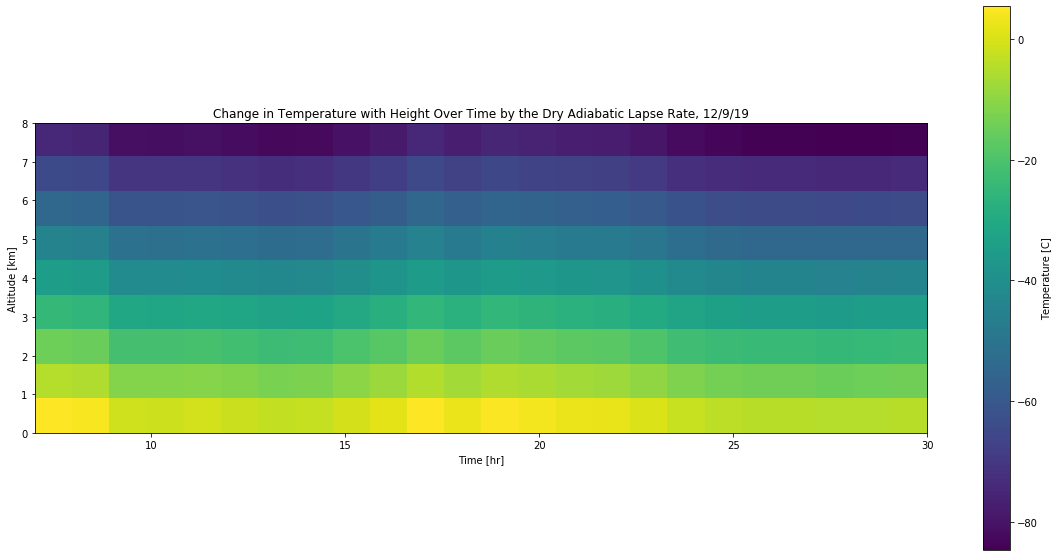

In [14]:
#Calculate the temperature every increasing kilometer using the dry adiabatic lapse rate (-10 C/m)
end_time = int(utc_p[-1])

#Make an array of each hour
hourly_times = np.linspace(start_time, end_time, end_time - start_time + 1)

hourly_index = []
for i in range(len(hourly_times)):
    #Find closest array index to each hour
    hourly_index.append(np.argmin(abs(utc_p - hourly_times[i])))
    

lapse_temp = np.zeros((len(hourly_times), 9))
for i in range(len(hourly_times)):
    for j in range(9):
        #Calculate lapse rate temperature from zero to eight km
        lapse_temp[i][j] = surface_temp[hourly_index[i]] - j*10

size = [hourly_times[0], hourly_times[-1], 0, 8]

        

fig = plt.figure(figsize = [20, 10])
plt.imshow(np.flipud(np.transpose(lapse_temp)), extent = size)
plt.colorbar(label='Temperature [C]')
plt.xlabel('Time [hr]')
plt.ylabel('Altitude [km]')
plt.title('Change in Temperature with Height Over Time by the Dry Adiabatic Lapse Rate, 12/9/19')
plt.show()

The image above shows the decreasing temperatures with altitude as calculated by the dry adiabatic lapse rate. The temperatures from this plot are compared to the cloud base temperatures derived from the pyrgeometer to estimate the cloud base height. 

#### Compare Lapse Temperatures to Derived Temperature From Pyrgeometer

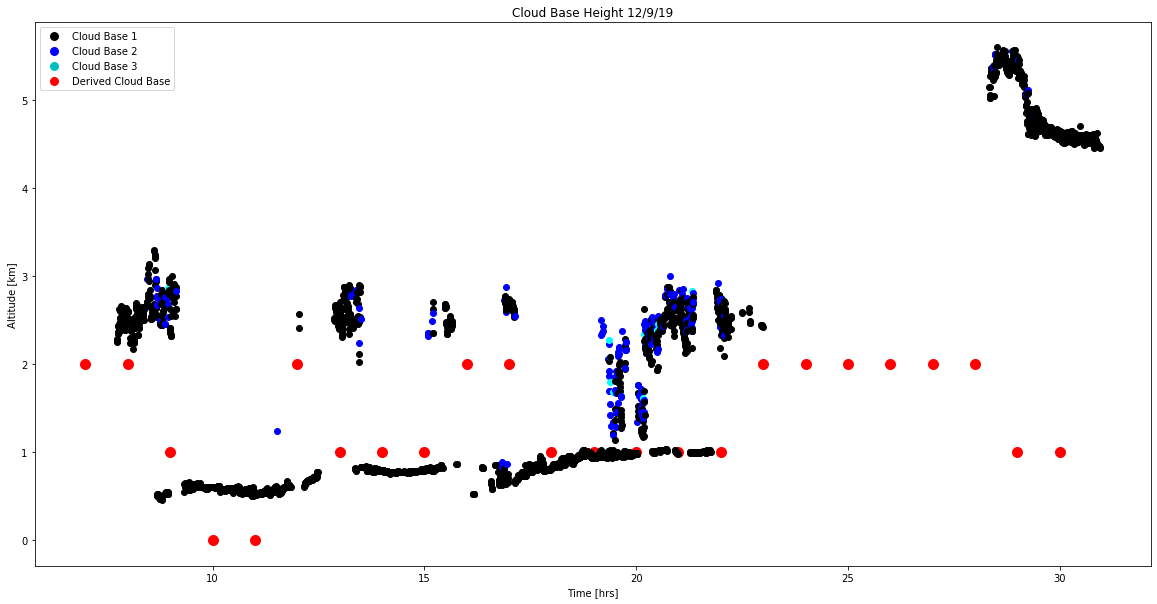

In [15]:
height_index = np.zeros(len(hourly_times)) #Preallocate
for i in range(len(hourly_times)):
    #Find the derived cloud height be comparing the lapse rate temperature to the derived temperature at each time
    height_index[i] = np.argmin(abs(lapse_temp[i] - T_derived[hourly_index[i]]))

#Overplot the derived cloud base temperatures on the cloud height plot
plt.figure(figsize = [20, 10])
plt.scatter(hourly_times, height_index, s=100, color = 'red')
    
for i in range(len(cloud_base1)):
    
    if cloud_base1[i] != 0: 
        plt.plot(utc[i], cloud_base1[i], 'o', color = 'black')
        
    if cloud_base2[i] != 0:
        plt.plot(utc[i], cloud_base2[i], 'o', color= 'blue')
    
    if cloud_base3[i] != 0:
        plt.plot(utc[i], cloud_base3[i], 'o', color= 'cyan')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cloud Base 1', markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Cloud Base 2', markerfacecolor='b', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Cloud Base 3', markerfacecolor='c', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Derived Cloud Base', markerfacecolor='r', markersize=10)]

plt.legend(handles=legend_elements)

        
plt.xlabel('Time [hrs]')
plt.ylabel('Altitude [km]')
plt.title('Cloud Base Height 12/9/19')
plt.show()




The figure above shows the resulting derived cloud base heights (in red) from the method above. As evident by this image, calculating cloud height using the dry adiabatic lapse rate is not terribly accurate. In reality, Boulder often sits in an inversion, so the dry adiabatic lapse rate may not even apply for the altitudes we are looking at. However, it provides a rough estimate. 

#### Climatology

There were 13 cloudy days in 2013.
There were 142 sunny days in 2013.


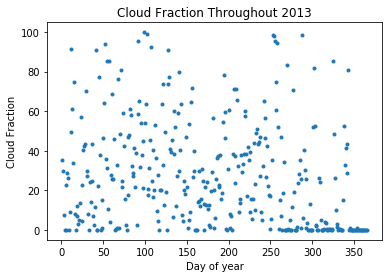

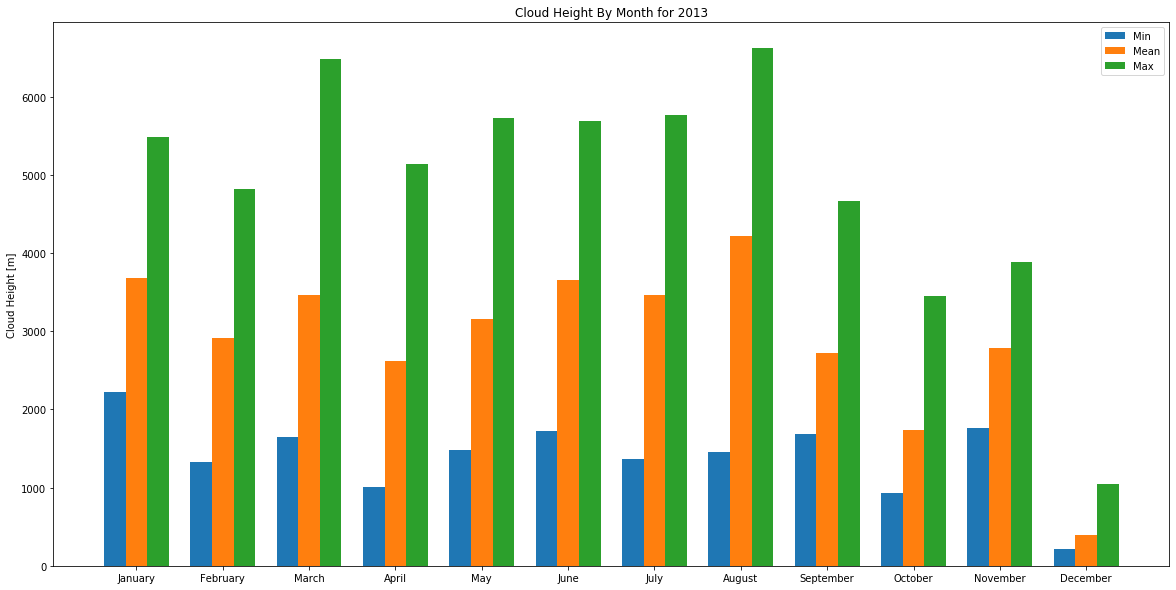

There were 21 cloudy days in 2018.
There were 118 sunny days in 2018.


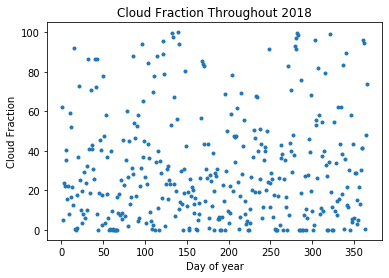

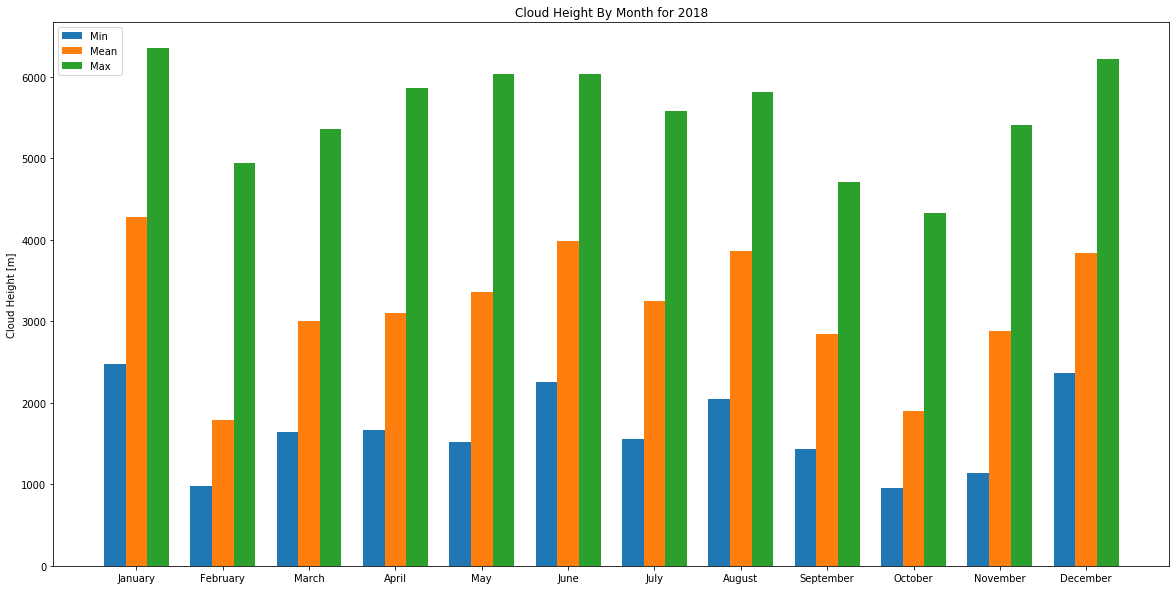

In [26]:
%matplotlib inline

class cloud_height:
    
    def __init__(self, date, dataset,h5 = None): 
        
        #If there is not an existing file, read the data from the skywatch website. 
        if h5 is None: # If "h5" keyword was not set, then we actually need to read the file from the web, rather than restoring it from the hard drive
            url = 'https://skywatch.colorado.edu/data/'
            # get julian day (requested date)
            y0=int(date[0:4]); m0=int(date[5:7]); d0= int(date[8:10])       
            jul    = [] # initialize julian day
            loc    = [] # initialize local times
            dat1    = [] # cloud base 1 [m]
            dat2    = [] # cloud base 2 [m]
            dat3    = [] # cloud base 3 [m]
            #get url based on selected dataset and date
            url=url+dataset+date[2:]+'.dat'
            print('Reading: ',url)
            hh0=0.          # incremented by 24 each time we pass midnight
            loc0previous=0. # retains current time; if time switches back below that, will increment "hh0"
            jday = (datetime.datetime(y0,m0,d0)-datetime.datetime(y0,1,1)).total_seconds()/86400.0 + 1.0
            try:
                lines  = urllib.request.urlopen(url).readlines()
                for line in lines[5:]: # go through all lines, ignoring first three (header)
                    entries = line.decode("utf-8").split("\t")
                    columns = []       # will contain columns
                    for entry in entries:
                        if len(entry) > 1: columns.append(entry)
                 
                    hhmmX = columns[0] # assigns time, filling in leading '0'
                    hh    = float(hhmmX[0:2])
                    self.doy = jday
                    mm    = float(hhmmX[3:5])
                    ss    = float(hhmmX[6:8])
                    loc0  = hh+mm/60.+ss/3600.+hh0
                    
                    #Make sure data is continuous and does not start over at 0 once time gets past 23 hrs. 
                    if loc0<loc0previous:
                        hh0=hh0+24.
                        loc0=loc0+hh0
                    loc0previous=loc0
                    loc.append(loc0)
                    jul.append(jday+loc0/24.) 
                    dat1.append(float(columns[1]))
                    dat2.append(float(columns[2]))
                    dat3.append(float(columns[3]))
            except:
                print("website not found ",date)
                pass
            self.jul = np.array(jul)
            self.loc = np.array(loc)
            self.h1 = np.array(dat1)
            self.h2 = np.array(dat2)
            self.h3 = np.array(dat3)
            self.date = date
            self.doy  = int(jday)
            self.year = date[0:4]
        else:
        #Check to see if there is an existing file. If so read that, not the website data. This will allow for 
        #faster reading of data
           h5f = h5py.File(h5, "r")
           self.jul = h5f['jul'][...]
           self.loc = h5f['loc'][...]
           self.h1  = h5f['h1'][...]
           self.h2  = h5f['h2'][...]
           self.h3  = h5f['h3'][...]
           self.date= str(h5f['date'][...])
           self.doy = int(h5f['doy'][...])
           self.year= str(h5f['year'][...])
           try: # If statistics exist, restore them, if not set them to zero
               self.cf=float(h5f['cf'][...])
               self.min=float(h5f['min'][...])
               self.max=float(h5f['max'][...])
               self.mean=float(h5f['mean'][...])
           except:
               self.cf=0
               self.min=0
               self.max=0
               self.mean=0
           h5f.close()           

    #This function will plot the cloud base height for a day of a specified year with altitude. 
    def plot(self):
        plt.plot(self.loc,self.h1,'k.')
        plt.xlabel('Local Time [h]')
        plt.ylabel('Cloud Base Height [m]')
        plt.title(self.date+' Cloud Fraction '+str(round(self.cf,1))+'%')

    
    #This function calculates the mean, max, and min cloud base heights for a day as well as the cloud fraction. 
    def stats(self): # of lowest cloud layer, calculate min, max, mean of day & cloud fraction
        tot=len(self.h1) # total number of data points
        flt=np.where(self.h1>0)
        cld=len(flt[0])  # number of cloudy data points
        if len(flt[0]>0):
            mn =np.min(self.h1[flt])
            mx =np.max(self.h1[flt])
            mm =np.mean(self.h1[flt])
            self.min=mn
            self.max=mx
            self.mean=mm
        
        #Gets rid of a few days in which the ceilometer was not working. 
        if tot != 0:
            self.cf = float(cld)/float(tot)*100.

        else:
            self.cf = 0.
    
    #This function saves the data calculated to an h5 file for future use and faster run time
    def save(self):
        file = './'+self.year+'_'+str(int(self.doy)).zfill(3)+'.h5'
        print('Saving data to: '+file)
        h5 = h5py.File(file, "w")
        h5['jul'] = self.jul
        h5['loc'] = self.loc
        h5['h1']  = self.h1
        h5['h2']  = self.h2
        h5['h3']  = self.h3
        h5['date']= self.date
        h5['doy'] = self.doy
        h5['year']= self.year
        if hasattr(self,'mean'):
            h5['mean']= self.mean
            h5['min'] = self.min
            h5['max'] = self.max
            h5['cf']  = self.cf
        h5.close()

#This function converts the julian day to the form yyyymmdd.
def jday2yyyymmdd(y,jd):
    month = 1
    while jd - calendar.monthrange(y,month)[1] > 0 and month <= 12:
        jd = jd - calendar.monthrange(y,month)[1]
        month = month + 1
    return(y,month,jd)

#This function calculates the statistics of cloud base height for a whole month. It averages the mean, max, and min 
#heights from each day to get one value for the entire month. 
def monthly_stats(y, doy_list, mean_list, max_list, min_list):
    y,m,d = jday2yyyymmdd(y, doy_list[-1])
    month_list = np.linspace(1, m, m)
    day_in_year = 0
    mean_month = np.zeros(len(month_list))
    min_month = np.zeros(len(month_list))
    max_month = np.zeros(len(month_list))
    for i in month_list:
        
        days_in_month = calendar.monthrange(y,int(i))[1]
        mean_month[int(i-1)] = np.mean(mean_list[day_in_year:days_in_month + day_in_year])
        min_month[int(i-1)] = np.mean(min_list[day_in_year:days_in_month + day_in_year])
        max_month[int(i-1)] = np.mean(max_list[day_in_year:days_in_month + day_in_year]) 
        
        day_in_year += days_in_month


    return(month_list, mean_month, min_month, max_month)


if __name__ == '__main__':

    # Test one day
    if False:
        doy = 345
        y,m,d = jday2yyyymmdd(2019,doy)
        date  = str(y).zfill(2)+'_'+str(m).zfill(2)+'_'+str(d).zfill(2)    
        ch=cloud_height(date,'ceil_')
        ch.stats()   
        ch.plot()   

    # Read range of dates in a year, do some simple statistics, and write everything to individual h5 files for  a day
    if True:
        year  = [2013, 2018]
        for i in range(len(year)):
            m0,d0 = 1,1    # start (m,d)
            m1,d1 = 12,31  # end (m,d)
            j0    = int((datetime.datetime(year[i],m0,d0)-datetime.datetime(year[i],1,1)).total_seconds()/86400.0 + 1.0)
            j1    = int((datetime.datetime(year[i],m1,d1)-datetime.datetime(year[i],1,1)).total_seconds()/86400.0 + 1.0)
        
            doy_list = []
            cf_list  = []
            mean_list  = []
            min_list  = []
            max_list  = []
            cloudy_days = 0
            sunny_days = 0
            for doy in range(j0,j1+1):
                doy_list.append(doy) # keep track of days
                y,m,d = jday2yyyymmdd(year[i],doy)
                date  = str(y).zfill(2)+'_'+str(m).zfill(2)+'_'+str(d).zfill(2)  
                # First, check if h5 file is already in existance for this date
                h5 = '../dat/'+str(year[i])+'_'+str(doy).zfill(3)+'.h5'
                if os.path.isfile(h5):
                    #print('Open and read '+h5)
                    ch = cloud_height(date,'ceil_h',h5=h5)
                else:
                    ch=cloud_height(date,'ceil_')
                    ch.stats()   
                    ch.save()   
               # print('Cloud fraction that day:',round(ch.cf,2),'%')
                cf_list.append(ch.cf) # keep track of cloud fraction
                mean_list.append(ch.mean) # keep track of mean
                min_list.append(ch.min) # keep track of min
                max_list.append(ch.max) # keep track of max
            
                #How many days of sunshine? Threshold = 87.5%
                if ch.cf > 87.5: #If there is more than 87.5% clouds, it is a cloudy day.
                    cloudy_days += 1
                if ch.cf < 12.5:
                    sunny_days += 1 #Less than 12.5% means sunny day!
        
            print('There were %d cloudy days in %d.' %(cloudy_days,year[i]))
            print('There were %d sunny days in %d.' %(sunny_days,year[i]))
        
            mean_list = np.array(mean_list)
            min_list = np.array(min_list)
            max_list = np.array(max_list)
        
            #Plot the cloud fraction for each day of the year. 
            plt.plot(doy_list,cf_list,'.')
            plt.xlabel('Day of year')
            plt.ylabel('Cloud Fraction')
            plt.title('Cloud Fraction Throughout %d' %(year[i]))
            plt.show()
        
        
            month_list, mean_month, min_month, max_month = monthly_stats(year[i], doy_list, mean_list, max_list, min_list)
       
            #Create a histogram with the monthly mean, min, and max cloud heights for one year. 
            labels = calendar.month_name[1:int(month_list[-1]) + 1]
            x = np.arange(len(labels))  # the label locations
            width = 0.25  # the width of the bars
    
            fig, ax = plt.subplots(figsize = [20, 10])
            rects1 = ax.bar(x - width, min_month, width, label='Min')
            rects2 = ax.bar(x, mean_month, width, label='Mean')
            rects3 = ax.bar(x + width, max_month, width, label='Max')
        
            # Add some text for labels, title and custom x-axis tick labels, etc.
            ax.set_ylabel('Cloud Height [m]')
            ax.set_title('Cloud Height By Month for %d' %(year[i]))
            ax.set_xticks(x)
            ax.set_xticklabels(labels)
            ax.legend()
            plt.show()
        

        

The first figure shows the cloud fraction for everyday of 2018. It is evident that there are more small cloud fractions than large meaning a large amount of the year sees sunny days or days with little clouds. The second figure shows a histogram of the min, mean, and max cloud heights for each month of the year. For the years 2013 and 2018, it seems that cloud heights increase in the summer, which makes sense since the summer boundary layer is typically deeper. Cloud heights also seem to increase in the winter months of December and January. This is more pronounced in 2018. In the spring and fall, cloud heights are generally lower. 

## Discussion

#### Programming Challenges

- The ceilometer dataset is very large and therefore it takes a very long time to read in just one day's worth of data. This causes extremely long runtimes when attempting to look at multiple years of data. Run times were mitigated by saving the data in h5 files to access later. 

- Plotting all the backscatter data proved challenging due to the volume of data at hand.

- No units are given in the dataset for backscatter radiation, so this had to be left as an unknown.

- Assuming the dry adiabatic lapse rate is not very accurate in deriving cloud height. 

- There was no elegant way to filter out 'zero' or nonexistant cloud heights from the data set, which either made presentation of the data difficult or required additional processing time.

- For some reason with the reader used for the climatology, only the data from years 2013 and 2018 could be extracted and saved as h5 files. Checking with the Skywatch website, data is definitely available, so something is occuring within the data or the reader itself that is not allowing these years to be imported in. 

#### Contributions

All data readers were taken from class but each reader was specialized to read the ceilometer and pyrgeometer data. All of the calculations for deriving cloud base temperature were our own contributions. The CLOUDS class was borrowed from another in class lab and tailored to our needs. The final data reader used to save h5 files was created by Sebastian and edited by Matt and Lara. Thanks Sebastian for all of your help!

#### Team Member Roles

- Matt: Code, report writing
- Lara: Code, report writing

#### Github Link:

https://github.com/festivefish/skywatch_ceilometer